### Limma voom analysis of AD/PD dataset

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(50))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [2]:
#load ATAC-seq raw read counts
data=read.table('adpd.atac.counts.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$chrom,data$start,data$end,sep="_")
data$chrom=NULL
data$start=NULL
data$end=NULL

data=data[rowSums(data)>0,]


In [7]:
head(data)

,ADAD_CAUD_00_0281,ADAD_CAUD_00_0387,ADAD_CAUD_01_0164,ADAD_CAUD_01_1400,ADAD_CAUD_06_0194,ADAD_CAUD_06_1486,ADAD_CAUD_07_0787,ADAD_CAUD_12829xx,ADAD_CAUD_23156xx,ADAD_CAUD_24281xx,⋯,LRRK_MDTG_01_39,LRRK_MDTG_04_10,LRRK_MDTG_10_37,LRRK_MDTG_13_60,LRRK_PTMN_01_39,LRRK_PTMN_04_10,LRRK_PTMN_10_37,LRRK_PTMN_13_60,LRRK_SUNI_04_10,LRRK_SUNI_10_37
chr1_9996_10236,12,16,22,12,14,20,12,22,16,10,⋯,3,2,14,18,0,4,12,9,22,26
chr1_180769_180986,6,13,7,4,7,10,6,11,4,10,⋯,3,4,8,9,2,11,7,4,10,10
chr1_181327_181563,1,6,4,2,10,6,1,10,1,3,⋯,1,5,2,14,0,4,7,4,8,18
chr1_183499_184320,25,15,18,28,5,43,46,60,19,35,⋯,2,57,53,65,10,43,34,22,63,56
chr1_184356_184577,7,6,6,1,6,11,6,11,5,9,⋯,5,17,12,18,1,13,7,4,23,15
chr1_190744_191148,84,95,136,110,43,163,97,186,66,158,⋯,6,70,122,46,8,78,46,36,79,93


In [8]:
#load the metadata
batches=read.table("batches.filtered.csv",header=TRUE,sep='\t')

In [9]:
tail(batches)

,Sample,Type,Group,Region,Cohort,Library,Gender
406,LRRK_PTMN_01_39,LRRK,ADPD,PTMN,PD,L022,Male
407,LRRK_PTMN_04_10,LRRK,ADPD,PTMN,PD,L041,Male
408,LRRK_PTMN_10_37,LRRK,ADPD,PTMN,PD,L033,Female
409,LRRK_PTMN_13_60,LRRK,ADPD,PTMN,PD,L061,Male
410,LRRK_SUNI_04_10,LRRK,ADPD,SUNI,PD,L035,Male
411,LRRK_SUNI_10_37,LRRK,ADPD,SUNI,PD,L045,Female


In [10]:
head(batches)

Sample,Type,Group,Region,Cohort,Library,Gender
ADAD_CAUD_00_0281,ADAD,GENA,CAUD,AD,L051,Male
ADAD_CAUD_00_0387,ADAD,GENA,CAUD,AD,L075,Female
ADAD_CAUD_01_0164,ADAD,GENA,CAUD,AD,L055,Male
ADAD_CAUD_01_1400,ADAD,GENA,CAUD,AD,L053,Male
ADAD_CAUD_06_0194,ADAD,GENA,CAUD,AD,L045,Male
ADAD_CAUD_06_1486,ADAD,GENA,CAUD,AD,L041,Male


## Normalize the data with voom 

In [11]:
tpm=voom(data,normalize.method = "quantile")
E=tpm$E


## Perform PCA analysis 

In [12]:
data.pca=prcomp(t(E))

In [13]:
var_explained=as.character(round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2))


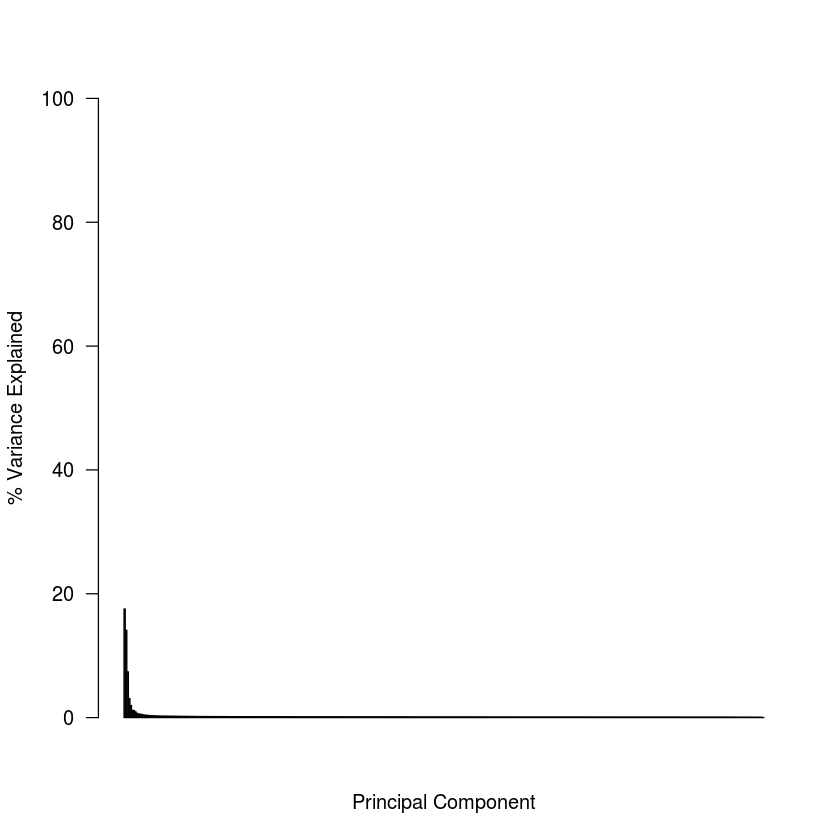

In [18]:
barplot(100*data.pca$sdev^2/sum(data.pca$sdev^2),las=2,ylab="% Variance Explained",xlab="Principal Component",ylim=c(0,100))

In [20]:
var_explained

[1] "17.54" "14.11" "7.39"  "3.08"  "1.96"  "1.18"  "1.13"  "0.92"  "0.69" 
 [10] "0.59"  "0.54"  "0.51"  "0.45"  "0.4"   "0.37"  "0.36"  "0.33"  "0.31" 
 [19] "0.3"   "0.29"  "0.28"  "0.27"  "0.25"  "0.25"  "0.25"  "0.24"  "0.23" 
 [28] "0.23"  "0.23"  "0.22"  "0.22"  "0.22"  "0.21"  "0.21"  "0.21"  "0.21" 
 [37] "0.21"  "0.2"   "0.2"   "0.2"   "0.2"   "0.19"  "0.19"  "0.19"  "0.19" 
 [46] "0.19"  "0.18"  "0.18"  "0.18"  "0.18"  "0.18"  "0.18"  "0.18"  "0.18" 
 [55] "0.17"  "0.17"  "0.17"  "0.17"  "0.17"  "0.17"  "0.17"  "0.17"  "0.17" 
 [64] "0.17"  "0.17"  "0.16"  "0.16"  "0.16"  "0.16"  "0.16"  "0.16"  "0.16" 
 [73] "0.16"  "0.16"  "0.16"  "0.16"  "0.16"  "0.16"  "0.16"  "0.16"  "0.15" 
 [82] "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15" 
 [91] "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15" 
[100] "0.15"  "0.15"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14" 
[109] "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14" 
[118] "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14" 
[127] "0.14"  "0.14"  "0.14"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13" 
[136] "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13" 
[145] "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13" 
[154] "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13" 
[163] "0.13"  "0.13"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12" 
[172] "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12" 
[181] "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12" 
[190] "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12" 
[199] "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.11"  "0.11" 
[208] "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11" 
[217] "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11" 
[226] "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11" 
[235] "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11" 
[244] "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11" 
[253] "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11" 
[262] "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"  
[271] "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"  
[280] "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"  
[289] "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"  
[298] "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"  
[307] "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"  
[316] "0.1"   "0.1"   "0.1"   "0.1"   "0.09"  "0.09"  "0.09"  "0.09"  "0.09" 
[325] "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09" 
[334] "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09" 
[343] "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09" 
[352] "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09" 
[361] "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09" 
[370] "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08" 
[379] "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08" 
[388] "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08" 
[397] "0.08"  "0.07"  "0.07"  "0.07"  "0.07"  "0.07"  "0.07"  "0.07"  "0.07" 
[406] "0.07"  "0.07"  "0.06"  "0.06"  "0.06"  "0"

In [21]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)

In [22]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC409,PC410,PC411,Sample,Type,Group,Region,Cohort,Library,Gender
ADAD_CAUD_00_0281,-158.85095,-345.54236,33.074785,193.189608,-67.59000,-10.141223,6.013880,-81.065931,86.3983925,-51.049413,⋯,2.37917311,-0.17681513,1.090544e-12,ADAD_CAUD_00_0281,ADAD,GENA,CAUD,AD,L051,Male
ADAD_CAUD_00_0387,118.55803,-362.64859,197.364000,64.229539,-85.72007,-203.688494,-158.106784,-90.742125,-65.1626336,-48.274495,⋯,0.53836611,0.26323237,-1.055437e-12,ADAD_CAUD_00_0387,ADAD,GENA,CAUD,AD,L075,Female
ADAD_CAUD_01_0164,12.80499,-379.06472,386.140122,169.865317,-49.57631,-49.463134,-110.143943,-210.061642,43.5592066,-34.719669,⋯,1.99937027,0.09977070,1.951464e-12,ADAD_CAUD_01_0164,ADAD,GENA,CAUD,AD,L055,Male
ADAD_CAUD_01_1400,146.88879,-513.51282,278.796091,201.624083,-52.92829,-33.442482,-7.712924,-102.851792,-32.2603365,32.373979,⋯,-0.78822900,1.45291857,-1.716164e-12,ADAD_CAUD_01_1400,ADAD,GENA,CAUD,AD,L053,Male
ADAD_CAUD_06_0194,214.15945,-541.54085,-162.518895,-21.013149,-25.72514,-74.748795,-11.281263,-116.703270,-36.4258527,-13.324108,⋯,-1.08380906,0.85130750,3.079721e-12,ADAD_CAUD_06_0194,ADAD,GENA,CAUD,AD,L045,Male
ADAD_CAUD_06_1486,163.15649,-398.96594,290.349963,149.098639,-81.58720,-54.123436,-43.562440,-163.828632,-9.2933654,-44.511575,⋯,0.47693283,-0.94397922,2.147230e-12,ADAD_CAUD_06_1486,ADAD,GENA,CAUD,AD,L041,Male
ADAD_CAUD_07_0787,-156.60523,-195.77876,213.168819,88.671147,-41.06733,11.652907,-22.818076,-113.222059,-55.1598257,21.077948,⋯,0.11972859,-0.76063190,4.123035e-12,ADAD_CAUD_07_0787,ADAD,GENA,CAUD,AD,L037,Male
ADAD_CAUD_12829xx,57.38715,-152.34575,423.952447,191.931555,-58.94892,-6.783937,-30.820320,-106.471284,64.1609212,81.361628,⋯,1.47650062,-0.67383417,1.310582e-12,ADAD_CAUD_12829xx,ADAD,GENA,CAUD,AD,L009,Male
ADAD_CAUD_23156xx,-360.82714,-92.92438,57.181884,155.716600,-67.30340,-53.251859,-28.736053,96.167538,14.5530979,0.364166,⋯,-10.06131326,-1.45610460,-8.369976e-14,ADAD_CAUD_23156xx,ADAD,GENA,CAUD,AD,L053,Female
ADAD_CAUD_24281xx,190.14645,-569.20528,309.518501,192.775063,-31.58192,-45.838733,-119.973836,1.928575,-17.2200571,21.225502,⋯,1.25182056,1.61528259,-1.760927e-12,ADAD_CAUD_24281xx,ADAD,GENA,CAUD,AD,L025,Female


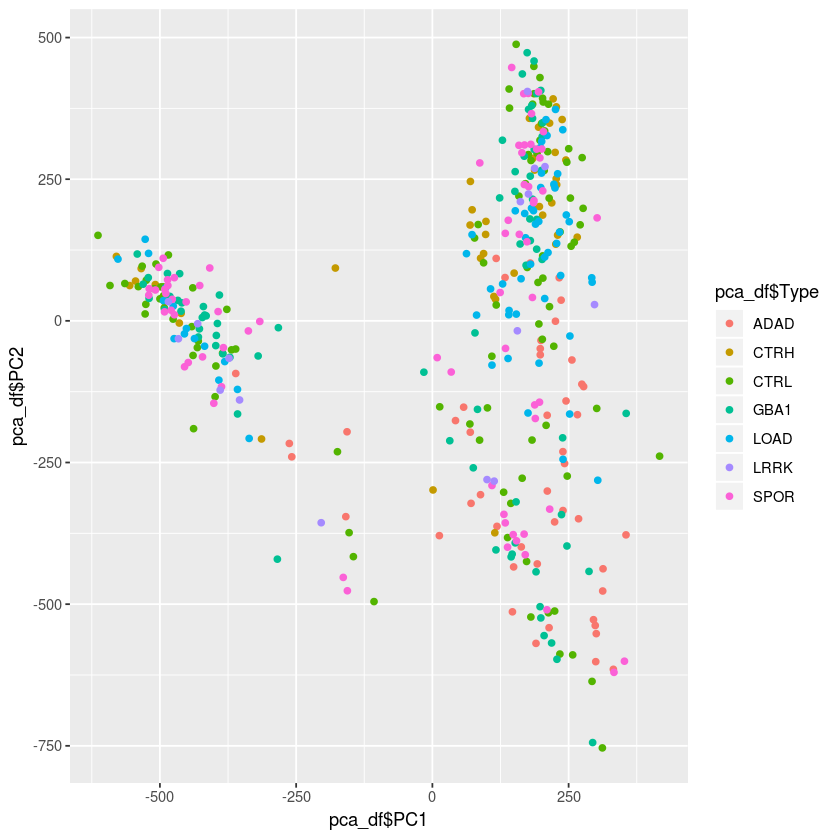

In [28]:
ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Type))+
geom_point()#,shape=pca_df$Region))
#+
#  xlab("PC1")+
#  ylab("PC2")+
#  theme_bw(20)+
#  scale_color_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'),name="Type"))
#p1
#svg("pca.1.2.svg",width = 8, height = 4, pointsize = 12)
#print(p1)
#dev.off()

In [ ]:
p2=ggplot(data=pca_df,aes(x=pca_df$PC2,y=pca_df$PC3,color=pca_df$Type,shape=pca_df$Region))+
  xlab("PC2")+
  ylab("PC3")+
  theme_bw(20)+
  scale_color_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'),name="Type")+
p2
svg("pca.2.3.svg",width = 8, height = 4, pointsize = 12)
print(p2)
dev.off()

In [ ]:
p3=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC3,color=pca_df$Type,shape=pca_df$Region))+
  xlab("PC1")+
  ylab("PC3")+
  theme_bw(20)+
  scale_color_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'),name="Type")+
p3
svg("pca.1.3.svg",width = 8, height = 4, pointsize = 12)
print(p3)
dev.off()